#### Imports

In [31]:
from datetime import timedelta
import json
import pprint
from copy import deepcopy

import cufflinks
cufflinks.go_offline()
import numpy as np
from numpy.polynomial import Polynomial
import pandas as pd
from tqdm.notebook import tqdm

from pyrecoy.assets import Heatpump, Eboiler, GasBoiler, WaterStorage
from pyrecoy.colors import *
from pyrecoy.converters import *
from pyrecoy.financial import calculate_eb_ode, get_tax_tables, get_tax_rate, get_grid_tariffs_electricity
from pyrecoy.framework import TimeFramework
from pyrecoy.casestudy import CaseStudy
from pyrecoy.plotting import ebitda_bar_chart, npv_bar_chart
from pyrecoy.reports import CaseReport, ComparisonReport, BusinessCaseReport, SingleFigureComparison
from pyrecoy.sensitivity import SensitivityAnalysis
from pyrecoy.prices import get_tennet_data, get_afrr_capacity_fees_nl
from pyrecoy.forecasts import Mipf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Development backlog

* aFRR (can improve the optimisation case)
* Report

--
* Create strategy on imbalance POS (buy 100% day-ahead, and respond to high prices)
* Graphs
    * EBITDA vs. baseline (earnings vs baseline)
* Show COP curves in different cases, just for illustration
* Energy report --> Check + add gas
* Fix comparison reports
* Model verification

#### Meeting Notes

##### Meeting 25-11-2020

* aFRR can help optimisation case
* SDE++ should be included
* Tsource sensitivity really gives interesting insights
* Sensitivities should be verified (especially CO2, Tsink, Tsource, time period)
* AP TNO: Update/verify COP curve
* AP TNO: Update CAPEX
* AP Mark: 
    * Create graphs on COP curve with different Tsource, Tsink
    * Generate table and output in .csv (send it to Andrew)
* Investigate opportunity to lower the COP and negative electricity prices
    * Technically feasible, but not really needed/possible to do it in this project
* Could be interesting to run this model on a usecase with higher delta T
* Conclusion: Finalize this model, but not add too much extra complexity, next steps is to go towards industrial partners with the results

# ENCORE : Heatpump Optimisation Framework

***
© Mark Kremer  
July 2020
##### Cases
In this model, 3 cases are compared:
* **Baseline** : All heat is supplied by steam turbine
* **Heatpump case** : All heat is supplied by heatpump
* **Hybrid case** : Steam turbine and heatpump run in hybrid mode, and are optimised on costs in real-time

#### Loading config

In [32]:
class Config():
    start = '2019-01-01'
    end = '2019-12-31'
    
    hp_vdg_e_power = 23.3 # MW
    hp_ndg_e_power = 7.7 # MW
    hp_min_load = 0.3
    hp_lifetime = 25
    hp_capex = 200_000 # EUR/MWth
    hp_opex = 0.01 # in % of CAPEX
    hp_devex = 0.005 # in % of CAPEX
    
    gb_power = 35 # MW
    gb_efficiency = 0.9
    
    tax_bracket_g = 4 
    tax_bracket_e = 4
    
    include_transport_costs = False
    grid_operator = 'Liander'
    connection_type = 'TS/MS'
    
    discount_rate = 0.1
    project_duration = 12

    forecast = 'ForeNeg'
    gas_price_multiplier = 1
    e_price_multiplier = 1
    e_price_volatility_multiplier = 1
    co2_price_multiplier = 1
    tsource_delta = 0
    tsink_delta = 0
    energy_tax_multiplier = 1
    
    # Review the SDE implementation
    sde_base_amount = 81
    longterm_gas_price = 24.00
    longterm_co2_price = 37.90
    sde_switch_price_correction = 40
    
    day_ahead_buying_perc = 0.3
    
    afrr_capacity_fee = 25_000
    Tref = 273 #K
    Cp = 4190 #J/kgK
    
    tank_max_power=10,
    tank_min_power=-10,
    tank_roundtrip_eff=0.90,
    tank_energy_density = 50 * 10e-3,
    tank_volume = 500,
    tank_lifetime = 25,
    tank_temperature = 368, #K
    min_storagelevel = 5,
    max_storagelevel = 23,
    tank_capex_per_MW = 3_000,
    tancapex_per_MWh = 10_000

c = Config()

In [33]:
c.Tref

273

In [34]:
class Store():
    pass

## Model set-up

In [35]:
def load_demand_data(c, s):
    demand = pd.read_csv('data/smurfit_demand_preprocessed.csv', delimiter=';', decimal=',')
    dt_index = pd.date_range(
        start=s.time_fw.start,
        end=s.time_fw.start + timedelta(days=365), freq='1T',
        closed='left',
        tz='Europe/Amsterdam')
    demand.index = dt_index
    demand['Total demand'] = demand['MW (VDG)'] + demand['MW (NDG)']
    demand = demand[c.start:c.end]
    return demand


In [36]:
def setup_model(c):
    s = Store()
    
    s.time_fw = TimeFramework(start=c.start, end=c.end)
    mipf = Mipf(
        start=s.time_fw.start, 
        end=s.time_fw.end, 
        tidy=True, 
        include_nextQ=True, 
        folder_path=r"C:\Users\Shahla Huseynova\Recoy\Recoy - Documents\03 - Libraries\12 - Data Management\Forecast Data"
    ).data
    
    s.baseline = CaseStudy(time_fw=s.time_fw, freq='1T', name='Baseline')
    s.hpcase = CaseStudy(time_fw=s.time_fw, freq='1T', name='Heatpump only', data=mipf)
    s.hpcase_sde = CaseStudy(time_fw=s.time_fw, freq='1T', name='Heatpump + SDE', data=mipf)
    s.optcase1 = CaseStudy(time_fw=s.time_fw, freq='1T', name='Optimisation', data=mipf)
    s.afrr_case = CaseStudy(time_fw=s.time_fw, freq='1T', name='Optimisation + aFRR', data=mipf)
    s.hp_storage_case = CaseStudy(time_fw=s.time_fw, freq='1T', name='Heatpump + Storage', data=mipf)
    
    s.cases = list(CaseStudy.instances.values())
    s.optcases = [s.hpcase, s.hpcase_sde, s.optcase1, s.afrr_case, s.hp_storage_case]
    s.sde_cases = [s.hpcase_sde, s.optcase1, s.afrr_case]
    
    s.demand = load_demand_data(c, s)
    return s

s = setup_model(c)
s.optcases

c:\users\shahla huseynova\python\29 - pyrecoy modelling framework\pyrecoy\pyrecoy\framework.py:35: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.

c:\users\shahla huseynova\python\29 - pyrecoy modelling framework\pyrecoy\pyrecoy\framework.py:35: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.

c:\users\shahla huseynova\python\29 - pyrecoy modelling framework\pyrecoy\pyrecoy\framework.py:35: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.

c:\users\shahla huseynova\python\29 - pyrecoy modelling framework\pyrecoy\pyrecoy\framework.py:35: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.

c:\users\shahla huseynova\python\29 - pyrecoy modelling framework\pyrecoy\pyrecoy\framework.py:35: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.

C:\Users\SHAHLA~1\AppData\Local\Temp/ipykernel_17920/4233922362.py:3: FutureWarning:

Argument `closed` is deprecated in favor of `incl

In [37]:
demand = load_demand_data(c, s)
demand

C:\Users\SHAHLA~1\AppData\Local\Temp/ipykernel_17920/4233922362.py:3: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



Tsource (VDG)  Tsink (VDG)  MW (VDG)  \
2019-01-01 00:00:00+01:00         64.990      143.360      0.00   
2019-01-01 00:01:00+01:00         64.985      143.089      0.00   
2019-01-01 00:02:00+01:00         64.980      142.818      0.00   
2019-01-01 00:03:00+01:00         64.975      142.547      0.00   
2019-01-01 00:04:00+01:00         64.970      142.276      0.00   
...                                  ...          ...       ...   
2019-12-31 23:55:00+01:00         65.050      129.970     17.04   
2019-12-31 23:56:00+01:00         65.050      129.970     17.04   
2019-12-31 23:57:00+01:00         65.050      129.970     17.04   
2019-12-31 23:58:00+01:00         65.050      129.970     17.04   
2019-12-31 23:59:00+01:00         65.050      129.970     17.04   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)  Total demand  
2019-01-01 00:00:00+01:00         20.510      147.620      0.00          0.00  
2019-01-01 00:01:00+01:00         20.387      147.642      0.00          0.00  
2019-01-01 00:02:00+01:00         20.264      147.664      0.00          0.00  
2019-01-01 00:03:00+01:00         20.141      147.686      0.00          0.00  
2019-01-01 00:04:00+01:00         20.018      147.708      0.00          0.00  
...                                  ...          ...       ...           ...  
2019-12-31 23:55:00+01:00         67.070      129.350      5.69         22.73  
2019-12-31 23:56:00+01:00         67.070      129.350      5.69         22.73  
2019-12-31 23:57:00+01:00         67.070      129.350      5.69         22.73  
2019-12-31 23:58:00+01:00         67.070      129.350      5.69         22.73  
2019-12-31 23:59:00+01:00         67.070      129.350      5.69         22.73  

[525600 rows x 7 columns]

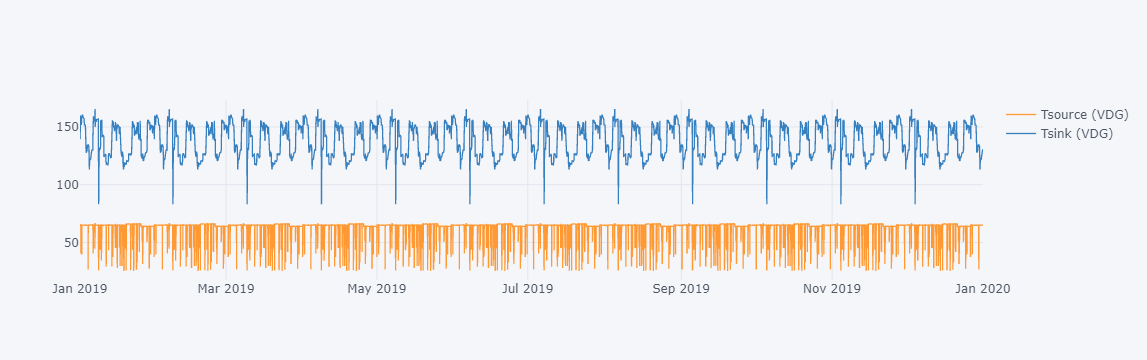

In [38]:
demand.resample('15T').mean()[['Tsource (VDG)', 'Tsink (VDG)']].iplot()

In [39]:
demand.describe()

Tsource (VDG)    Tsink (VDG)       MW (VDG)  Tsource (NDG)  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean       63.658798     138.637674      17.636712      62.176305   
std         6.422773      14.328580       5.123252      10.252555   
min        25.310000      82.480000       0.000000      13.540000   
25%        64.892000     126.074000      17.014000      63.516000   
50%        64.991000     142.450000      19.892000      64.313000   
75%        65.076000     151.730000      20.819000      65.546000   
max        70.070000     166.020000      23.250000      73.470000   

         Tsink (NDG)       MW (NDG)   Total demand  
count  525600.000000  525600.000000  525600.000000  
mean      145.351645       5.823824      23.460537  
std        14.896056       1.691697       6.814125  
min       106.330000       0.000000       0.000000  
25%       131.551500       5.612000      22.676000  
50%       148.490000       6.540000      26.441000  
75%       158.100000       6.880000      27.690000  
max       172.050000       7.650000      30.900000

## Load in data

In [40]:
def add_afrr_prices(c, case):
    try:
        aFRR_signal = pd.read_csv(f'data/aFRR_{c.start}.csv', delimiter=';', decimal=',', index_col='datetime')
        aFRR_signal.index = case.data.index
    except:
        data = get_tennet_data('balansdelta2017', pd.to_datetime(c.start), pd.to_datetime(c.end))
        data.index = data[["datum", "tijd"]].apply(lambda x: " ".join(x), axis=1)
        data.index = pd.to_datetime(data.index, format="%d-%m-%Y %H:%M").tz_localize(
            "Europe/Amsterdam", ambiguous=True
        )
        data = data[~data.index.duplicated(keep="first")]
        date_ix = pd.date_range(
            data.index[0], data.index[-1], freq="1T", tz="Europe/Amsterdam"
        )
        data = data.reindex(date_ix)
        aFRR_signal = data[['Hoogste_prijs_opregelen', 'Mid_prijs_opregelen', 'Laagste_prijs_afregelen']]
        aFRR_signal.to_csv(f'data/aFRR_{c.start}.csv', sep=';', decimal=',', index_label='datetime')

    try:
        aFRR_prices = pd.read_csv(f'data/aFRR_prices_{c.start}.csv', delimiter=';', decimal=',', index_col='datetime')
        aFRR_prices.index = case.data.index
    except:
        data = get_aFRR_prices_nl(pd.to_datetime(c.start), pd.to_datetime(c.end))
        data.index = pd.date_range(
            start=c.start,
            end=pd.to_datetime(c.end) + timedelta(days=1),
            tz='Europe/Amsterdam', 
            freq='15T', 
            closed='left'
        )
        aFRR_prices = data.reindex(case.data.index, method='ffill')
        aFRR_prices.to_csv(f'data/aFRR_prices_{c.start}.csv', sep=';', decimal=',', index_label='datetime')
        
    case.data = pd.concat([case.data, aFRR_signal, aFRR_prices], axis=1)
    return case

In [41]:
def increase_volatility_by_factor(col, factor):
    mean = col.mean()
    diff_to_mean = col - mean
    new_diff = diff_to_mean * factor
    return mean + new_diff

def multiply_by_factor(col, factor):
    mean = col.mean()
    diff_to_mean = col - mean
    
    cond = diff_to_mean > 0
    diff_to_mean[cond] *= factor
    diff_to_mean[~cond] /= factor
    return mean + diff_to_mean

In [42]:
def load_data(c, s):
    s.afrr_case = add_afrr_prices(c, s.afrr_case)
    
    for case in s.cases:
        case.add_gasprices()
        case.add_co2prices(perMWh=True)
        
        case.data['Gas prices (€/MWh)'] *= c.gas_price_multiplier
        case.data['CO2 prices (€/MWh)'] *= c.co2_price_multiplier
        case.data['CO2 prices (€/ton)'] *= c.co2_price_multiplier
        
    for case in s.optcases:
        case.data['NEG'] = multiply_by_factor(case.data['NEG'], c.e_price_multiplier)
        case.data['ForeNeg'] = multiply_by_factor(case.data['ForeNeg'], c.e_price_multiplier)
        case.data['DAM'] = multiply_by_factor(case.data['DAM'], c.e_price_multiplier)
        
        case.data['NEG'] = increase_volatility_by_factor(case.data['NEG'], c.e_price_volatility_multiplier)
        case.data['ForeNeg'] = increase_volatility_by_factor(case.data['ForeNeg'], c.e_price_volatility_multiplier)
    
    for case in [s.afrr_case]:
        case.data['Hoogste_prijs_opregelen'] = multiply_by_factor(case.data['Hoogste_prijs_opregelen'], c.e_price_multiplier)
        case.data['Hoogste_prijs_opregelen'] = increase_volatility_by_factor(case.data['Hoogste_prijs_opregelen'], c.e_price_volatility_multiplier)
        case.data['aFRR_up'] = multiply_by_factor(case.data['aFRR_up'], c.e_price_multiplier)
        case.data['aFRR_up'] = increase_volatility_by_factor(case.data['aFRR_up'], c.e_price_volatility_multiplier)
        
    s.demand[['Tsource (VDG)', 'Tsource (NDG)']] += c.tsource_delta
    s.demand[['Tsink (VDG)', 'Tsink (NDG)']] += c.tsink_delta
    for case in s.cases:
        case.data = pd.concat([case.data, s.demand], axis=1)        

    s.eb_ode_g = get_tax_rate('gas', 2020, 4)['EB+ODE'] * c.energy_tax_multiplier
    s.eb_ode_e = get_tax_rate('electricity', 2020, 4)['EB+ODE'] * c.energy_tax_multiplier
    s.grid_fees = get_grid_tariffs_electricity(c.grid_operator, 2020, c.connection_type)
    s.grid_fee_per_MWh = s.grid_fees['kWh tarief'] * 1000
    return s

s = load_data(c, s)

## Assets

### COP curve

In [43]:
def cop_curve(Tsink, Tsource):
    Tsink += 273
    Tsource += 273

    c1 = 0.267 * Tsink / (Tsink - Tsource)
    c2 = 0.333 * Tsink / (Tsink - Tsource)
    
    return Polynomial([c2, c1])

In [44]:
cop_curve(140, 13)

Polynomial([1.08290551, 0.86827559], domain=[-1,  1], window=[-1,  1])

In [45]:
cop_curve(140, 73)

Polynomial([2.05267164, 1.64583582], domain=[-1,  1], window=[-1,  1])

In [46]:
heatpump = Heatpump(
    name='Heatpump',
    max_th_power=1,
    min_th_power=0,
    cop_curve=cop_curve
)

In [47]:
#heatpump.get_cop(heat_output=load, Tsink=140, Tsource=13)

In [48]:
#heatpump.get_cop(heat_output=load, Tsink=140, Tsource=99)

In [49]:
import itertools

source_Ts = np.arange(25, 75) + 273
sink_Ts   = np.arange(80, 170) + 273

df = pd.DataFrame(columns=list(sink_Ts), index=list(source_Ts))
for sourceT, sinkT in itertools.product(source_Ts, sink_Ts):
    df.loc[sourceT, sinkT] = heatpump.get_cop(heat_output=0.5, Tsink=sinkT, Tsource=sourceT)
    
#df.to_csv('cops_at_50perc_load.csv', sep=';', decimal=',')

In [50]:
sourceT = 63 + 273
sinkT = 140 + 273
loads = np.arange(0, 1, 0.01)

cop_series = pd.Series(index=loads, dtype='float')
load_series = pd.Series(index=loads, dtype='float')
for load in loads:
    cop = heatpump.get_cop(heat_output=load, Tsink=sinkT, Tsource=sourceT)
    cop_series[load] = cop
    load_series[load] = load / cop 

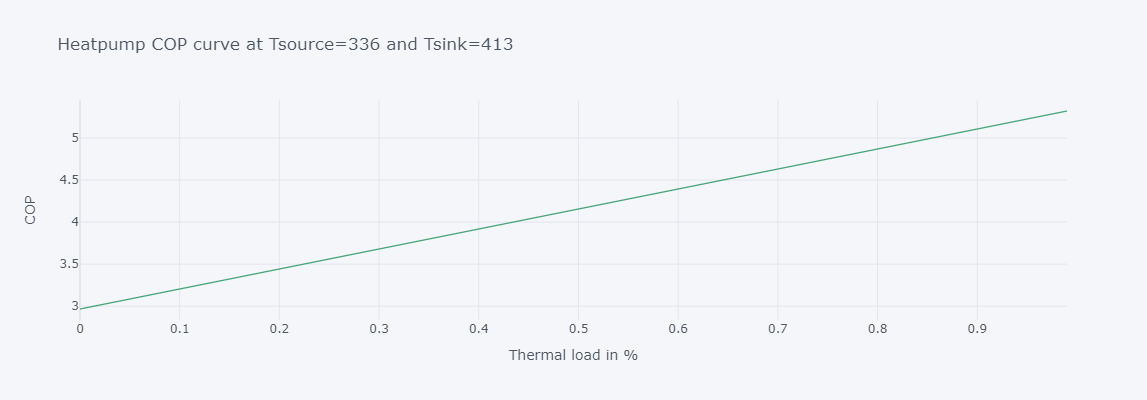

In [51]:
fig_cop_curve = cop_series.iplot(title=f'Heatpump COP curve at Tsource={sourceT} and Tsink={sinkT}', yTitle='COP', xTitle='Thermal load in %', colors=recoygreen, asFigure=True, dimensions=(600,400))
fig_cop_curve

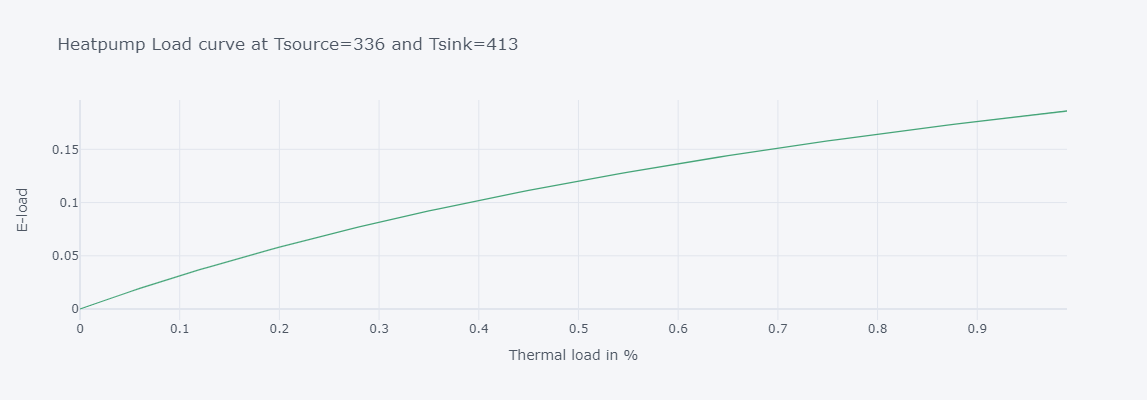

In [52]:
fig_load_curve = load_series.iplot(title=f'Heatpump Load curve at Tsource={sourceT} and Tsink={sinkT}', yTitle='E-load', xTitle='Thermal load in %', colors=recoygreen, asFigure=True, dimensions=(600,400))
fig_load_curve

In [53]:
def cop_curve_new(Tsink, Tsource):
    Tsink += 273
    Tsource += 273
    Tlift = Tsink - Tsource

    c0 = 0.0005426*Tlift**2 - 0.1178*Tlift + 6.962
    c1 = 6.7058 
    c2 = -1.79
    
    return Polynomial([c0, c1, c2])

In [54]:
sourceT = 63 + 273
sinkT = 140 + 273
cop_curve_new(sourceT, sinkT)

Polynomial([19.2496754,  6.7058   , -1.79     ], domain=[-1,  1], window=[-1,  1])

In [55]:
heatpump = Heatpump(
    name='Heatpump',
    max_th_power=1,
    min_th_power=0,
    cop_curve=cop_curve_new
)

In [56]:
import itertools

source_Ts = np.arange(25, 75) + 273
sink_Ts   = np.arange(80, 170) + 273

df = pd.DataFrame(columns=list(sink_Ts), index=list(source_Ts))
for sourceT, sinkT in itertools.product(source_Ts, sink_Ts):
    df.loc[sourceT, sinkT] = heatpump.get_cop(heat_output=0.5, Tsink=sinkT, Tsource=sourceT)
    
#df.to_csv('cops_at_50perc_load.csv', sep=';', decimal=',')

In [57]:
sourceT = 63 + 273
sinkT = 140 + 273
loads = np.arange(0, 1, 0.01)

cop_series = pd.Series(index=loads, dtype='float')
load_series = pd.Series(index=loads, dtype='float')
for load in loads:
    cop = heatpump.get_cop(heat_output=load, Tsink=sinkT, Tsource=sourceT)
    cop_series[load] = cop
    load_series[load] = load / cop 

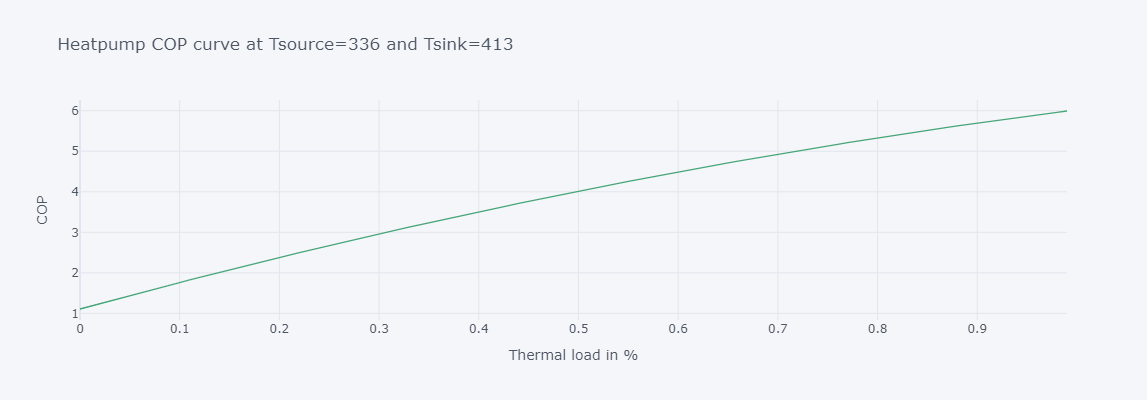

In [58]:
fig_cop_curve = cop_series.iplot(title=f'Heatpump COP curve at Tsource={sourceT} and Tsink={sinkT}', yTitle='COP', xTitle='Thermal load in %', colors=recoygreen, asFigure=True, dimensions=(600,400))
fig_cop_curve

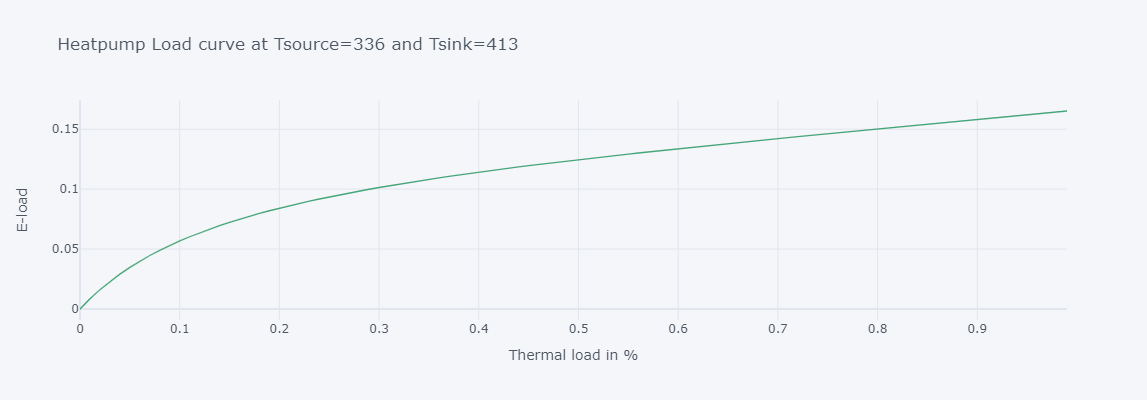

In [59]:
fig_load_curve = load_series.iplot(title=f'Heatpump Load curve at Tsource={sourceT} and Tsink={sinkT}', yTitle='E-load', xTitle='Thermal load in %', colors=recoygreen, asFigure=True, dimensions=(600,400))
fig_load_curve

### Create and assign assets

In [60]:
def create_and_assign_assets(c, s):
    heatpump_vdg = Heatpump(
        name='Heatpump VDG',
        max_th_power=c.hp_vdg_e_power,
        min_th_power=c.hp_vdg_e_power * c.hp_min_load,
        cop_curve=cop_curve_new
    )

    heatpump_ndg = Heatpump(
        name='Heatpump NDG',
        max_th_power=c.hp_ndg_e_power,
        min_th_power=c.hp_ndg_e_power * c.hp_min_load,
        cop_curve=cop_curve_new
    )

    capex_vdg = c.hp_capex*(heatpump_vdg.max_th_power) 
    capex_ndg = c.hp_capex*(heatpump_ndg.max_th_power)
    heatpump_vdg.set_financials(capex=capex_vdg, opex=c.hp_opex*capex_vdg, devex=c.hp_devex*capex_vdg, lifetime=25)
    heatpump_ndg.set_financials(capex=capex_ndg, opex=c.hp_opex*capex_ndg, devex=c.hp_devex*capex_ndg, lifetime=25)

    gasboiler = GasBoiler(
        name='Gasboiler',
        max_th_output=c.gb_power,
        efficiency=c.gb_efficiency
    )
    gasboiler.set_financials(capex=0, opex=0, devex=0, lifetime=25)
    
    tank = WaterStorage(
        name='MyStorage',
        max_power= c.tank_max_power,
        min_power= c.tank_min_power,
        roundtrip_eff= c.tank_roundtrip_eff,
        energy_density = c.tank_energy_density,
        volume = c.tank_volume,
        lifetime = c.tank_lifetime,
        temperature = c.tank_temperature, #K
        min_storagelevel = c.min_storagelevel,
        max_storagelevel = c.max_storagelevel
    
    )
    tank.set_financials(
        capex_per_MW = c.tank_Capex_per_MW, 
        capex_per_MWh = c.tank_capex_per_MWh, 
        opex = 2_000, 
        devex = 0, 
        lifetime = 25
    )

#     tank.set_financials(
#         capex_per_MW,
#         capex_per_MWh,
#         2_000,
#         0,
#         lifetime=30
#     )
    
    s.hp_storagecase.add_asset(tank)
    s.baseline.add_asset(gasboiler)
    s.hpcase.add_asset(heatpump_vdg)
    s.hpcase.add_asset(heatpump_ndg)
    s.hpcase_sde.add_asset(heatpump_vdg)
    s.hpcase_sde.add_asset(heatpump_ndg)
    s.optcase1.add_asset(heatpump_vdg)
    s.optcase1.add_asset(heatpump_ndg)
    s.optcase1.add_asset(gasboiler)
    s.afrr_case.add_asset(heatpump_vdg)
    s.afrr_case.add_asset(heatpump_ndg)
    s.afrr_case.add_asset(gasboiler)
    return s

s = create_and_assign_assets(c, s)

TypeError: can't multiply sequence by non-int of type 'tuple'

In [ ]:
tank.name

## Optimization

### Strategies

In [ ]:
def baseline_sim(case):
    gasboiler = list(case.assets.values())[0]
    data = case.data
    demand = (data['MW (VDG)'] + data['MW (NDG)']).to_list()

    minutes = iter(range(len(case.data)))
    th_output = [0] * len(case.data)
    gas_input = [0] * len(case.data)

    for m in minutes:
        th_output[m], gas_input[m] = gasboiler.set_heat_output(demand[m])

    data['output_MW_th'] = np.array(th_output)
    data['output_MWh_th'] = np.array(data['output_MW_th']/60)
    data['gb_input_MW'] = np.array(gas_input)
    data['gb_input_MWh'] = np.array(data['gb_input_MW']/60)
    case.data = data.round(5)

In [ ]:
def hponly(case):
    hp_vdg = case.assets['Heatpump VDG']
    hp_ndg = case.assets['Heatpump NDG']
    demand_vdg = case.data['MW (VDG)'].to_list()
    demand_ndg = case.data['MW (NDG)'].to_list()
    Tsink_vdg = case.data['Tsink (VDG)'].to_list()
    Tsink_ndg = case.data['Tsink (NDG)'].to_list()
    Tsource_vdg = case.data['Tsource (VDG)'].to_list()
    Tsource_ndg = case.data['Tsource (NDG)'].to_list()

    hp_vdg_input = [0] * len(case.data)
    hp_ndg_input = [0] * len(case.data)
    hp_vdg_output = [0] * len(case.data)
    hp_ndg_output = [0] * len(case.data)

    minutes = iter(range(len(case.data)))
    for m in minutes:
        demand = demand_vdg[m]
        if demand != 0:
            hp_vdg_input[m], hp_vdg_output[m] = hp_vdg.set_heat_output(
                heat_output=demand,
                Tsink=Tsink_vdg[m],
                Tsource=Tsource_vdg[m]
            )

        demand = demand_ndg[m]
        if demand != 0:
            hp_ndg_input[m], hp_ndg_output[m] = hp_ndg.set_heat_output(
                heat_output=demand_ndg[m],
                Tsink=Tsink_ndg[m],
                Tsource=Tsource_ndg[m]
            )

    case.data['hp_output_MW'] = np.array(hp_vdg_output) + np.array(hp_ndg_output)
    case.data['hp_input_MW'] = np.array(hp_vdg_input) + np.array(hp_ndg_input)
    
    for col in case.data.columns:
        if col.endswith('MW'):
            case.data[col + 'h'] = case.data[col] / 60

    case.data = case.data.round(3)

In [ ]:
def cost_function(th_load, cop, electricity_cost, alt_heat_price, demand):
        return (
            th_load / cop * electricity_cost
            + (demand - th_load) * alt_heat_price
        )

In [ ]:
def hybrid_imb_optimisation(case, decimals, s):
    gb = case.assets['Gasboiler']
    hp_vdg = case.assets['Heatpump VDG']
    hp_ndg = case.assets['Heatpump NDG']
    demand_vdg = case.data['MW (VDG)'].round(decimals).to_list()
    demand_ndg = case.data['MW (NDG)'].round(decimals).to_list()
    Tsink_vdg = case.data['Tsink (VDG)'].round(decimals).to_list()
    Tsink_ndg = case.data['Tsink (NDG)'].round(decimals).to_list()
    Tsource_vdg = case.data['Tsource (VDG)'].round(decimals).to_list()
    Tsource_ndg = case.data['Tsource (NDG)'].round(decimals).to_list()
    fore_neg = case.data[c.forecast].fillna(999).round(decimals).to_list()
    gas_prices = case.data['Gas prices (€/MWh)'].round(decimals).to_list()
    co2_prices = case.data['CO2 prices (€/MWh)'].round(decimals).to_list()
    eb_ode_g = s.eb_ode_g
    eb_ode_e = s.eb_ode_e
    
    gb_input = [0] * len(case.data)
    gb_output = [0] * len(case.data)

    minutes = range(len(case.data))
    hp_output = [0] * len(case.data)
    hp_input = [0] * len(case.data)

    for m in tqdm(minutes):
        dem_vgd = demand_vdg[m]
        if dem_vgd != 0:
            max_load = min(hp_vdg.max_th_power, dem_vgd)
            min_load = hp_vdg.min_th_power
            Tsink = Tsink_vdg[m]
            Tsource = Tsource_vdg[m]
            cop_max_load = hp_vdg.get_cop(heat_output=max_load, Tsink=Tsink, Tsource=Tsource)
            cop_min_load = hp_vdg.get_cop(heat_output=min_load, Tsink=Tsink_vdg[m], Tsource=Tsource_vdg[m])
            
            cost_full_load = cost_function(
                th_load=max_load,
                cop=cop_max_load,
                electricity_cost=fore_neg[m] + eb_ode_e - c.sde_switch_price_correction,
                alt_heat_price=gas_prices[m] + co2_prices[m] + eb_ode_g/case.assets['Gasboiler'].efficiency,
                demand=dem_vgd
            )
            
            cost_min_load = cost_function(
                th_load=min_load,
                cop=cop_min_load,
                electricity_cost=fore_neg[m] + eb_ode_e,
                alt_heat_price=gas_prices[m] + co2_prices[m] + eb_ode_g/case.assets['Gasboiler'].efficiency,
                demand=dem_vgd
            )
            
            if cost_full_load < cost_min_load:
                hp_vdg_input, hp_vdg_output = hp_vdg.set_heat_output(max_load, Tsink, Tsource)
            else:
                hp_vdg_input, hp_vdg_output = hp_vdg.set_heat_output(min_load, Tsink, Tsource)
        else:
            hp_vdg_input, hp_vdg_output = (0, 0)

        dem_ngd = demand_ndg[m]
        if dem_ngd != 0:
            max_load = min(hp_ndg.max_th_power, dem_ngd)
            min_load = hp_ndg.min_th_power
            Tsink = Tsink_ndg[m]
            Tsource = Tsource_ndg[m]
            cop_max_load = hp_ndg.get_cop(heat_output=max_load, Tsink=Tsink, Tsource=Tsource)
            cop_min_load = hp_ndg.get_cop(heat_output=min_load, Tsink=Tsink, Tsource=Tsource)
            
            cost_full_load = cost_function(
                th_load=max_load,
                cop=cop_max_load,
                electricity_cost=fore_neg[m] + eb_ode_e,
                alt_heat_price=gas_prices[m] + co2_prices[m] + eb_ode_g/case.assets['Gasboiler'].efficiency,
                demand=dem_ngd
            )
            
            cost_min_load = cost_function(
                th_load=min_load,
                cop=cop_min_load,
                electricity_cost=fore_neg[m] + eb_ode_e,
                alt_heat_price=gas_prices[m] + co2_prices[m] + eb_ode_g/case.assets['Gasboiler'].efficiency,
                demand=dem_vgd
            )
            
            if cost_full_load <= cost_min_load:
                hp_ndg_input, hp_ndg_output = hp_ndg.set_heat_output(max_load, Tsink=Tsink, Tsource=Tsource)
            else:
                hp_ndg_input, hp_ndg_output = hp_ndg.set_heat_output(min_load, Tsink=Tsink, Tsource=Tsource)
        else:
            hp_ndg_input, hp_ndg_output = (0, 0)

        hp_out = hp_vdg_output + hp_ndg_output
        hp_output[m] = hp_out
        hp_input[m] = hp_vdg_input + hp_ndg_input
        remaining_demand = max(dem_vgd+dem_ngd-hp_out, 0)
        gb_output[m], gb_input[m] = gb.set_heat_output(remaining_demand)

    case.data['hp_output_MW'] = np.array(hp_output)
    case.data['hp_input_MW'] = np.array(hp_input)
    case.data['gb_output_MW'] = np.array(gb_output)
    case.data['gb_input_MW'] = np.array(gb_input)

    for col in case.data.columns:
        if col.endswith('MW'):
            case.data[col + 'h'] = case.data[col] / 60

    case.data = case.data.round(5)

aFRR
* Bid in a volume (X MW) --> Strategy is to only bid in on aFRR down
* Remaining demand is filed in by gasboiler
* Bid price at switch price?
* Assume direct response to 0% for now?


In [ ]:
def calc_afrr_capacity(case):
    hp_vdg = case.assets['Heatpump VDG']
    hp_ndg = case.assets['Heatpump NDG']
    
    capacity = 0
    for hp in [hp_vdg, hp_ndg]:
        max_th_output = hp.max_th_power
        cop = hp.get_cop(max_th_output, Tsink=135, Tsource=60)
        e_power = max_th_output / cop
        capacity += e_power
    return capacity

In [ ]:
def aFRR_optimisation(case, s):
    s.afrr_case.afrr_capacity = calc_afrr_capacity(s.afrr_case)
    gb = case.assets['Gasboiler']
    hp_vdg = case.assets['Heatpump VDG']
    hp_ndg = case.assets['Heatpump NDG']
    demand_vdg = case.data['MW (VDG)'].to_list()
    demand_ndg = case.data['MW (NDG)'].to_list()
    Tsink_vdg = case.data['Tsink (VDG)'].to_list()
    Tsink_ndg = case.data['Tsink (NDG)'].to_list()
    Tsource_vdg = case.data['Tsource (VDG)'].to_list()
    Tsource_ndg = case.data['Tsource (NDG)'].to_list()
    afrr_up = case.data['Hoogste_prijs_opregelen'].fillna(-999).to_list()
    gas_prices = case.data['Gas prices (€/MWh)'].to_list()
    co2_prices = case.data['CO2 prices (€/MWh)'].to_list()
    eb_ode_g = s.eb_ode_g
    eb_ode_e = s.eb_ode_e
    
    gb_input = [0] * len(case.data)
    gb_output = [0] * len(case.data)

    minutes = range(len(case.data))
    hp_output = [0] * len(case.data)
    hp_input = [0] * len(case.data)

    for m in tqdm(minutes):
        dem_vgd = demand_vdg[m]
        if dem_vgd != 0:
            max_load = min(hp_vdg.max_th_power, dem_vgd)
            min_load = hp_vdg.min_th_power
            Tsink = Tsink_vdg[m]
            Tsource = Tsource_vdg[m]
            cop_max_load = hp_vdg.get_cop(heat_output=max_load, Tsink=Tsink, Tsource=Tsource)
            cop_min_load = hp_vdg.get_cop(heat_output=min_load, Tsink=Tsink_vdg[m], Tsource=Tsource_vdg[m])
            
            cost_full_load = cost_function(
                th_load=max_load,
                cop=cop_max_load,
                electricity_cost=afrr_up[m] + eb_ode_e - c.sde_switch_price_correction,
                alt_heat_price=gas_prices[m] + co2_prices[m] + eb_ode_g/case.assets['Gasboiler'].efficiency,
                demand=dem_vgd
            )
            
            cost_min_load = cost_function(
                th_load=min_load,
                cop=cop_min_load,
                electricity_cost=afrr_up[m] + eb_ode_e,
                alt_heat_price=gas_prices[m] + co2_prices[m] + eb_ode_g/case.assets['Gasboiler'].efficiency,
                demand=dem_vgd
            )
            
            if cost_full_load < cost_min_load:
                hp_vdg_input, hp_vdg_output = hp_vdg.set_heat_output(max_load, Tsink, Tsource)
            else:
                hp_vdg_input, hp_vdg_output = hp_vdg.set_heat_output(min_load, Tsink, Tsource)
        else:
            hp_vdg_input, hp_vdg_output = (0, 0)

        dem_ngd = demand_ndg[m]
        if dem_ngd != 0:
            max_load = min(hp_ndg.max_th_power, dem_ngd)
            min_load = hp_ndg.min_th_power
            Tsink = Tsink_ndg[m]
            Tsource = Tsource_ndg[m]
            cop_max_load = hp_ndg.get_cop(heat_output=max_load, Tsink=Tsink, Tsource=Tsource)
            cop_min_load = hp_ndg.get_cop(heat_output=min_load, Tsink=Tsink, Tsource=Tsource)
            
            cost_full_load = cost_function(
                th_load=max_load,
                cop=cop_max_load,
                electricity_cost=afrr_up[m] + eb_ode_e,
                alt_heat_price=gas_prices[m] + co2_prices[m] + eb_ode_g/case.assets['Gasboiler'].efficiency,
                demand=dem_ngd
            )
            
            cost_min_load = cost_function(
                th_load=min_load,
                cop=cop_min_load,
                electricity_cost=afrr_up[m] + eb_ode_e,
                alt_heat_price=gas_prices[m] + co2_prices[m] + eb_ode_g/case.assets['Gasboiler'].efficiency,
                demand=dem_vgd
            )
            
            if cost_full_load <= cost_min_load:
                hp_ndg_input, hp_ndg_output = hp_ndg.set_heat_output(max_load, Tsink=Tsink, Tsource=Tsource)
            else:
                hp_ndg_input, hp_ndg_output = hp_ndg.set_heat_output(min_load, Tsink=Tsink, Tsource=Tsource)
        else:
            hp_ndg_input, hp_ndg_output = (0, 0)

        hp_out = hp_vdg_output + hp_ndg_output
        hp_output[m] = hp_out
        hp_input[m] = hp_vdg_input + hp_ndg_input
        remaining_demand = max(dem_vgd+dem_ngd-hp_out, 0)
        gb_output[m], gb_input[m] = gb.set_heat_output(remaining_demand)

    case.data['hp_output_MW'] = np.array(hp_output)
    case.data['hp_input_MW'] = np.array(hp_input)
    case.data['gb_output_MW'] = np.array(gb_output)
    case.data['gb_input_MW'] = np.array(gb_input)

    for col in case.data.columns:
        if col.endswith('MW'):
            case.data[col + 'h'] = case.data[col] / 60

    case.data = case.data.round(5)

### Run optimisation

In [61]:
def run_optimisation(c, s):
    s.baseline.assign_algorithm(baseline_sim)
    s.baseline.run()
    
    s.hpcase.assign_algorithm(hponly)
    s.hpcase.run()
    
    s.hpcase_sde.assign_algorithm(hponly)
    s.hpcase_sde.run()
    
    s.optcase1.assign_algorithm(hybrid_imb_optimisation)
    s.optcase1.run(decimals=2, s=s)
    
    s.afrr_case.assign_algorithm(aFRR_optimisation)
    s.afrr_case.run(s=s)
    
    for case in [s.hpcase, s.hpcase_sde, s.optcase1, s.afrr_case]:
        case.mean_cop = case.data['hp_output_MW'].sum() / case.data['hp_input_MW'].abs().sum()
    
    return s

s = run_optimisation(c, s)

NameError: name 'baseline_sim' is not defined

## Financials

In [ ]:
def calculate_sde_subsidy(c, s, case):
    hp_capacity = abs(case.assets['Heatpump VDG'].max_th_power) + abs(case.assets['Heatpump NDG'].max_th_power)
    case.full_load_hours = abs(case.data['hp_output_MWh'].sum() / hp_capacity)

    subsidized_hours = min(case.full_load_hours, 8000)
    subsidized_MWh = subsidized_hours * hp_capacity

    base_amount_per_MWh_th = round(c.sde_base_amount*0.173 + c.longterm_gas_price, 2)
    base_subsidy_amount = round(base_amount_per_MWh_th * subsidized_MWh, 2)
    long_term_gas_price_LHV = round(EURperHHV_to_EURperLHV(c.longterm_gas_price), 2)
    base_amount_gas = (2/3)*long_term_gas_price_LHV*0.9
    mean_ttf_price_LHV = round(EURperHHV_to_EURperLHV(case.data['Gas prices (€/MWh)'].mean()), 2)
    correction_amount_gas = max(mean_ttf_price_LHV, base_amount_gas)
    avoided_gas_consumption = subsidized_MWh/0.9
    correction_gas = round(correction_amount_gas * avoided_gas_consumption, 2)

    base_amount_co2 = (2/3)*c.longterm_co2_price
    avoided_co2_emission = avoided_gas_consumption * 0.226
    mean_ets_price = round(EURperHHV_to_EURperLHV(case.data['CO2 prices (€/ton)'].mean()), 2)
    correction_amount_co2 = max(base_amount_co2, mean_ets_price)
    correction_co2 = round(correction_amount_co2 * avoided_co2_emission, 2)

    sde_subsidy_corrected = max(base_subsidy_amount - (correction_gas + correction_co2), 0)
    sde_per_MWh_th = sde_subsidy_corrected / subsidized_MWh
    sde_per_MWh_e = sde_subsidy_corrected / case.data['hp_input_MWh'].abs().sum()

    case.sde_results = {
        'base_amount': base_subsidy_amount,
        'correction_gas': correction_gas,
        'correction_co2': correction_co2,
        'corrected_amount': sde_subsidy_corrected,
        'sde_per_MWh_th': sde_per_MWh_th,
        'sde_per_MWh_e': sde_per_MWh_e
    }
    return case

In [ ]:
def collect_cashflows(c, s):
    s.hpcase.generate_electr_market_results(nom_col='hp_input_MWh', real_col='hp_input_MWh')
    s.hpcase_sde.generate_electr_market_results(nom_col='hp_input_MWh', real_col='hp_input_MWh')
    
    s.optcase1.data['DA Nom'] = s.hpcase.data['hp_input_MWh'] * c.day_ahead_buying_perc
    s.optcase1.generate_electr_market_results(nom_col='DA Nom', real_col='hp_input_MWh')
    
    s.afrr_case.data['POS'] = s.afrr_case.data['aFRR_up'].fillna(value=s.afrr_case.data['POS'])
    s.afrr_case.data['DA Nom'] = s.hpcase.data['hp_input_MWh']
    s.afrr_case.generate_electr_market_results(nom_col='DA Nom', real_col='hp_input_MWh')
    s.afrr_case.add_cashflow('aFRR capacity fee (€)', c.afrr_capacity_fee * s.afrr_case.afrr_capacity)
    
    for case in [s.baseline, s.optcase1, s.afrr_case]:
        case.add_gas_costs(gasvolumes_col='gb_input_MWh')
        case.add_co2_costs(volume_cols='gb_input_MWh', fuel='gas')
        case.add_eb_ode(commodity='gas', tax_bracket=c.tax_bracket_g)
        
    for case in [s.hpcase, s.hpcase_sde, s.optcase1, s.afrr_case]:
        case.add_eb_ode(commodity='electricity', tax_bracket=c.tax_bracket_e)
        case.add_grid_costs(
            power_MW_col='hp_input_MW',
            grid_operator=c.grid_operator,
            year=2020, 
            connection_type=c.connection_type
        )
    for case in s.sde_cases:
        case = calculate_sde_subsidy(c=c, s=s, case=case)
        case.add_cashflow('SDE++ subsidy (€)', case.sde_results['corrected_amount'])
        
    return s

s = collect_cashflows(c, s)

In [ ]:
def calculate_financials(c, s):
    for case in s.cases:
        case.calculate_ebitda()

    for case in [s.hpcase, s.hpcase_sde, s.optcase1, s.afrr_case]:
        case.calculate_business_case(
            project_duration=c.project_duration, 
            discount_rate=c.discount_rate, 
            baseline=s.baseline
        )
        
    return s

s = calculate_financials(c, s)

In [ ]:
s.optcase1.cashflows

In [ ]:
s.optcase1.ebitda_calc

## Visualisations

In [ ]:
fig_demands_over_time = s.demand['Total demand'].resample('H').mean().iplot(
    title='Smurfit Kappa: Heat demand by Hour in MW', 
    yTitle='MW', 
    colors=recoygreen,
    asFigure=True,
    dimensions=(800, 400)
)
fig_demands_over_time

In [ ]:
demands_fig = s.demand[['Tsource (VDG)', 'Tsink (VDG)', 'Tsource (NDG)', 'Tsink (NDG)']].resample('H').mean().iplot(
    kind='box',
    title='Smurfit Kappa: Source and Sink temperatures',
    color=recoygreen,
    yTitle='Temperature in degrees C',
    legend=False,
    asFigure=True,
    dimensions=(800, 400)
)
demands_fig

In [ ]:
test_hp = Heatpump(
    name='Heatpump for Testing',
    max_th_power=1,
    min_th_power=0.3,
    cop_curve=cop_curve
)

In [ ]:
Tsrc_vdg, Tsnk_vdg, Tsrc_ndg, Tsnk_ndg = s.demand[['Tsource (VDG)', 'Tsink (VDG)', 'Tsource (NDG)', 'Tsink (NDG)']].mean().to_list()
mean_gas_price = (s.optcase1.data['Gas prices (€/MWh)'].mean() 
             + s.eb_ode_g 
             + s.optcase1.data['CO2 prices (€/MWh)'].mean()
            )

max_gas_price = (s.optcase1.data['Gas prices (€/MWh)'].max() 
             + s.eb_ode_g 
             + s.optcase1.data['CO2 prices (€/MWh)'].max()
            )

min_gas_price = (s.optcase1.data['Gas prices (€/MWh)'].min() 
             + s.eb_ode_g 
             + s.optcase1.data['CO2 prices (€/MWh)'].min()
            )

Tsrc_vdg_min, Tsnk_vdg_min, Tsrc_ndg_min, Tsnk_ndg_min = s.demand[['Tsource (VDG)', 'Tsink (VDG)', 'Tsource (NDG)', 'Tsink (NDG)']].min().to_list()
Tsrc_vdg_max, Tsnk_vdg_max, Tsrc_ndg_max, Tsnk_ndg_max = s.demand[['Tsource (VDG)', 'Tsink (VDG)', 'Tsource (NDG)', 'Tsink (NDG)']].max().to_list()

In [ ]:
def create_load_trace(gas_price, Tsnk, Tsrc, name):
    loads = []
    eprices = list(range(1000))
    for eprice in eprices:
        _, load = test_hp.set_opt_load(
            electricity_cost=eprice + s.eb_ode_e,
            alt_heat_price=gas_price / 0.9,
            demand=1, 
            Tsink=Tsnk,
            Tsource=Tsrc
        )
        loads.append(load)
    trace = go.Scatter(x=eprices, y=loads, name=name)
    return trace

In [ ]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()

configs = {
    'mean': [mean_gas_price, Tsnk_vdg, Tsrc_vdg],
    'unfav_gas': [min_gas_price, Tsnk_vdg, Tsrc_vdg],
    'fav_gas': [max_gas_price, Tsnk_vdg, Tsrc_vdg],
    'unfav_all': [min_gas_price, Tsnk_vdg_max, Tsrc_vdg_min],
    'fav_all': [max_gas_price, Tsnk_vdg_min, Tsrc_vdg_max],
}

for name, config in configs.items():
    trace = create_load_trace(*config, name)
    fig.add_trace(trace)

fig.update_layout(title='Switch prices for different configurations')
fig.show()

In [ ]:
date = s.baseline.data.index[0].strftime('%Y-%m-%d')

In [ ]:
fig_steamboiler = s.baseline.data[['Total demand', 'output_MW_th']].abs().loc[date, :].iplot(
    subplots=True, 
    title=f'Steamboiler only case on {date}',
    subplot_titles=['Total demand', 'Steam boiler output (MW)'],
    legend=False,
    dimensions=(800, 400),
    colors=[recoydarkblue, recoygreen], 
    asFigure=True,
    shape = (2, 1)
)
fig_steamboiler

In [ ]:
fig_heatpump = s.hpcase.data[['Total demand', 'hp_output_MW']].abs().loc[date, :].iplot(
    subplots=True, 
    title=f'Heatpump only case on {date}', 
    subplot_titles=['Total demand', 'Heatpump output (MW)'],
    legend=False,
    dimensions=(800, 400),
    colors=[recoydarkblue, recoygreen], 
    asFigure=True,
    shape = (2, 1)
)
fig_heatpump

In [ ]:
fig_optcase = s.optcase1.data[['hp_output_MW', 'gb_output_MW', 'NEG']].loc[date, :].iplot(
    subplots=True, 
    title=f'Hybrid case on {date}',
    subplot_titles=['Heatpump output (MW)', 'Steam boiler output (MW)', 'Imbalance price (€/MWh)'],
    legend=False,
    dimensions=(800, 600),
    colors=[recoydarkblue, recoygreen, recoyred],
    asFigure=True,
    shape=(3,1)
)
fig_optcase

In [ ]:
date = '2019-09-04'

fig_optcase2 = s.optcase1.data[['hp_output_MW', 'gb_output_MW', 'NEG']].loc[date, :].iplot(
    subplots=True, 
    title=f'Hybrid case on {date}',
    subplot_titles=['Heatpump output (MW)', 'Steam boiler output (MW)', 'Imbalance price (€/MWh)'],
    legend=False,
    dimensions=(800, 600),
    colors=[recoydarkblue, recoygreen, recoyred],
    asFigure=True,
    shape=(3,1)
)
fig_optcase2

In [ ]:
report = ComparisonReport(
    cases=s.optcases, 
    kind='electr_market_results',
)
report.show()

In [ ]:
casereport = ComparisonReport(cases = s.cases, kind='ebitda_calc', baseline=s.hpcase_sde, comparison='relative')
casereport.show(presentation_format=True)

In [ ]:
BusinessCaseReport(s.hpcase).show()

In [ ]:
#price chart
from copy import deepcopy

data = deepcopy(s.baseline.data)
data = data[data.columns[:2]]
data[data.columns[1]] = MWh_gas_to_tonnes_CO2(data[data.columns[1]])
data = data.rename(columns={"CO2 prices (€/ton)": "CO2 prices (€/MWh)"})

data.resample('D').mean().iplot(dimensions=(800, 300), title='Gasprices vs. CO2 prices', colors=recoycolors)

In [ ]:
#price chart
from copy import deepcopy

s.optcase1.data['DAM'].resample('D').mean().iplot(dimensions=(800, 300), title='Electricity Prices', colors=recoycolors)

In [ ]:
_source_output = s.optcase1.data[['hp_output_MWh', 'gb_output_MWh']].resample('M').sum()
_total_output = _source_output.sum(axis=1)
_data = _source_output.divide(_total_output, axis=0).rename(
    columns={'hp_output_MWh':'Heat pump', 'gb_output_MWh':'Gasboiler'}
) * 100

production_fig = _data.iplot(
    kind='bar',
    barmode='stack',
    colors=[recoydarkblue, recoygreen],
    title='Hybrid case: Heat production per Month by Source in % share',
    yTitle='Share of production in %',
    dimensions=(600, 400),
    asFigure=True
)

production_fig = production_fig.update_layout(legend_traceorder="reversed")
production_fig

In [ ]:
report = ComparisonReport(s.cases, kind='capex').report
report = report[report.index.str.contains('CAPEX')].T
capex_fig = report.iplot(
    kind='bar', 
    barmode='relative',
    colors=recoycolors,
    title='CAPEX by Casestudy',
    yTitle='CAPEX in €',
    dimensions=(600, 400),
    asFigure=True,
)

capex_fig = capex_fig.update_layout(legend_traceorder="reversed")
capex_fig

In [ ]:
cashflow_report = ComparisonReport(cases = s.cases, kind='cashflows')

fig = cashflow_report.report.T.iplot(
    kind='bar',
    barmode='relative',
    colors=recoycolors,
    title='OPEX breakdown',
    asFigure=True,
    yTitle='€',
    dimensions=(800, 600)
)

ebitda_report = ComparisonReport(cases=s.cases, kind='ebitda_calc')
scat = go.Scatter(
    mode='markers',
    y=ebitda_report.report.loc['EBITDA (€)', :].values, 
    x=ebitda_report.report.columns, 
    line=go.scatter.Line(color=recoydarkgrey),
    marker=dict(
        color=recoydarkgrey,
        size=20,
        line=dict(
            color=recoydarkgrey,
            width=3
        ),
        symbol='line-ew'
    ),
    name='EBITDA (€)'
)
fig.add_trace(scat)
fig

In [ ]:
_series = SingleFigureComparison(s.cases, 'ebitda', label='EBITDA').report
ebitda_graph = _series.iplot(
    kind='bar',
    title='Yearly EBITDA by Casestudy in €',
    colors=recoygreen,
    dimensions=(600, 400), 
    yTitle='EBITDA in €',
    asFigure=True,
    yrange=[_series.min() * 1.2, _series.max() * 2]
)

ebitda_graph.update_traces(
    text=_series.values/1000_000, 
    textposition='outside', 
    texttemplate="%{text:.1f}M €", 
)

ebitda_graph

In [ ]:
_series = SingleFigureComparison(s.optcases, 'npv', label='NPV').report

npv_graph = _series.iplot(
    kind='bar',
    title='NPV by Casestudy in €',
    colors=recoygreen,
    dimensions=(600, 400), 
    yTitle='NPV in €',
    asFigure=True,
    yrange=[0, _series.max() * 1.1]
)

npv_graph.update_traces(
    text=_series.values/1000_000, 
    textposition='outside', 
    texttemplate="%{text:.1f}M €", 
)

npv_graph

In [ ]:
irr_report = (SingleFigureComparison(s.optcases, 'irr', label='IRR').report * 100)
irr_fig = irr_report.iplot(
    kind='bar',
    title='IRR by Casestudy in %',
    colors=recoygreen,
    dimensions=(600, 400),
    yTitle='IRR in %',
    asFigure=True,
    yrange=[0, irr_report.max() * 1.2]
)

irr_fig.update_traces(
    text=irr_report.values, 
    textposition='outside', 
    texttemplate="%{text:.0f} %", 
)

irr_fig

In [ ]:
_series = (SingleFigureComparison(s.optcases, 'spp', label='Simple Payback Time').report)
spt_fig = _series.iplot(
    kind='bar',
    title='Simple Payback Time by Casestudy in Years',
    colors=recoygreen,
    dimensions=(600, 400),
    yTitle='Years',
    asFigure=True,
    yrange=[0, _series.max() * 1.2]
)

spt_fig.update_traces(
    text=_series.values, 
    textposition='outside', 
    texttemplate="%{text:.1f} years", 
)

spt_fig 

In [ ]:
(SingleFigureComparison(s.optcases, 'mean_cop', label='COP').report).iplot(
    kind='bar',
    title='Mean COP by Casestudy',
    colors=recoygreen,
    dimensions=(600, 400),
    yTitle='Years'
)

## Sensitivity analysis

We have agreed that for the sensitivity analysis we will vary the following key assumptions in the flex-model:
1. Market prices of gas and electricity. We will use the actual prices for 2019, the actual prices for 2020.
2. aFRR prices +/- 30%
3. CAPEX
4. CO2 price
5. Tsource +/- 10 degrees Celsius
6. Tsink
    * Roam off the peak / lower pressure
    * Stabalize / running average per hour/ 2 hours
7. __A scenario with a constraint on grid capacity and a scenario without grid capacity as a constraint__
8. Energy Tax and ODE +/- 30%

In [ ]:
def setup():
    _c = Config()
    s = setup_model(c=_c)
    return s

def routine(c, s):
    s = load_data(c=c, s=s)
    s = create_and_assign_assets(c=c, s=s)
    s = run_optimisation(c=c, s=s)
    s = collect_cashflows(c=c, s=s)
    s = calculate_financials(c=c, s=s)
    return s

In [ ]:
%time _s = setup()

In [ ]:
%time result = routine(c, _s)
npv = result.hpcase.npv
npv

### Sensitivity: Heat Pump CAPEX

In [ ]:
_s = setup()
configs = {}
values = [0.7, 1, 1.3, 2]
for value in values:
    _c = Config()
    _c.hp_capex *= value
    configs[value*100] = _c

In [ ]:
%%time
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('spp', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])

sens_capex = output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='CAPEX factor (%)',
    yTitle='Payback Period in years',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Heat Pump CAPEX (€)',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400),
    asFigure=True
)
sens_capex

### Sensitivity: CO2 prices

In [ ]:
_s = setup()
configs = {}
mean = 24.86
co2_prices = [10, 25, 50, 100]

for price in co2_prices:
    _c = Config()
    multiplier = price / mean
    _c.co2_price_multiplier = multiplier
    configs[price] = _c

In [ ]:
%%time
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('ebitda', case_names=['Baseline', 'Heatpump + SDE', 'Heatpump only', 'Optimisation', 'Optimisation + aFRR'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Mean CO2 price in €',
    yTitle='EBITDA in €',
    yrange=[output.min().min() * 1.1, 0],
    title='Sensitivity: CO2 prices > EBITDA',
    colors=[recoypurple, recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400),
    asFigure=True
)

In [ ]:
output = sens.single_kpi_overview('spp', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
sens_co2_spp = output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Mean CO2 price in €',
    yTitle='Payback Period in Years',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: CO2 prices',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400),
    asFigure=True
)
sens_co2_spp

In [ ]:
output = sens.single_kpi_overview('npv', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Mean CO2 price in €',
    yTitle='NPV in €',
    yrange=[output.min().min() * 10, output.max().max()*1.1],
    title='Sensitivity: CO2 prices > NPV',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400)
)

### Sensitivity: Gas prices

In [ ]:
_s = setup()
configs = {}
values = [0.7, 1, 1.3]
for value in values:
    _c = Config()
    _c.gas_price_multiplier = value
    configs[value * 100] = _c

In [ ]:
%%time
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('npv', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Gas price factor (%)',
    yTitle='NPV in €',
    yrange=[output.min().min()*1.5, output.max().max()*1.1],
    title='Sensitivity: Gas prices',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400)
)

### Sensitivity: Day Ahead buying amount

In [ ]:
_s = setup()
configs = {}
values = [0, 0.5, 1]
for value in values:
    _c = Config()
    _c.day_ahead_buying_perc = value
    configs[value * 100] = _c

In [ ]:
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('npv', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Volume in %',
    yTitle='NPV in €',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Volume bought on Day-Ahead market in %',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400)
)

### Sensitivity: Electricity prices

In [ ]:
_s = setup()
configs = {}
values = [0.7, 1, 1.3]
for value in values:
    _c = Config()
    _c.e_price_multiplier = value
    configs[value * 100] = _c

In [ ]:
sens = SensitivityAnalysis(_s, routine, configs)

### Sensitivity: Electricity price volatility

In [ ]:
_s = setup()
configs = {}
values = [0.7, 1, 1.3]
for value in values:
    _c = Config()
    _c.e_price_volatility_multiplier = value
    configs[value] = _c

In [ ]:
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('spp', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
sens_evol = output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Volatility factor',
    yTitle='Payback period in years',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: E-price volatility',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400),
    asFigure=True
)
sens_evol

### Sensitivity: aFRR capacity fee

In [ ]:
_s = setup()
configs = {}
values = [10_000, 25_000, 50_000]
for value in values:
    _c = Config()
    _c.afrr_capacity_fee = value
    configs[value] = _c

In [ ]:
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('spp', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
sens_affr_fee = output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='aFRR capacity fee in €/MW',
    yTitle='Payback Period in years',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: aFRR capacity fee',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400),
    asFigure=True
)
sens_affr_fee

### Sensitivity: Energy tax

In [ ]:
_s = setup()
configs = {}
values = [0.7, 1, 1.3]
for value in values:
    _c = Config()
    _c.energy_tax_multiplier = value
    configs[value] = _c

In [ ]:
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('npv', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Factor',
    yTitle='NPV in €',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Energy taxes',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400)
)

### Sensitivity: Tsource

In [ ]:
_s = setup()
configs = {}
values = [-25, -10, 0, 10, 25]
for value in values:
    _c = Config()
    _c.tsource_delta = value
    configs[value] = _c

In [ ]:
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('spp', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
output.loc[-25, 'Heatpump only'] = np.nan
sens_tsource = output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Tsource delta',
    yTitle='Payback Period in years',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Tsource',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400),
    asFigure=True
)
sens_tsource

In [ ]:
output = sens.single_kpi_overview('mean_cop', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Tsource delta',
    yTitle='COP',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Tsource > Mean COP',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400)
)

### Sensitivity: Tsink

In [ ]:
_s = setup()
configs = {}
values = [-25, -10, 0, 10, 25]
for value in values:
    _c = Config()
    _c.tsink_delta = value
    configs[value] = _c

In [ ]:
sens = SensitivityAnalysis(_s, routine, configs)

In [ ]:
output = sens.single_kpi_overview('spp', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
sens_tsink = output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Tsink delta',
    yTitle='Payback Period in Years',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Tsink',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400),
    asFigure=True
)
sens_tsink

In [ ]:
output = sens.single_kpi_overview('mean_cop', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
sens_tsink_cop = output.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Tsink delta',
    yTitle='COP',
    yrange=[0, output.max().max()*1.1],
    title='Sensitivity: Tsink > Mean COP',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400),
    asFigure=True
)
sens_tsink_cop

### Sensitivity: Time period

In [ ]:
def routine2(c, s):
    s = setup_model(c=c)
    s = load_data(c=c, s=s)
    s = create_and_assign_assets(c=c, s=s)
    s = run_optimisation(c=c, s=s)
    s = collect_cashflows(c=c, s=s)
    s = calculate_financials(c=c, s=s)
    return s

In [ ]:
configs = {}
start_values = ['2018-01-01', '2019-01-01', '2019-11-01']

for value in start_values:
    _c = Config()
    _c.start = value
    _c.end = (pd.to_datetime(value) + timedelta(days=364)).strftime('%Y-%m-%d')
    configs[value] = _c

In [ ]:
%%time
sens = SensitivityAnalysis(_s, routine2, configs)

In [ ]:
result = sens.single_kpi_overview('npv', case_names=['Heatpump only', 'Heatpump + SDE', 'Optimisation', 'Optimisation + aFRR'])
result.iplot(
    mode='lines+markers',
    symbol='circle-dot',
    size=10,
    xTitle='Start date',
    yTitle='NPV in €',
    yrange=[0, result.max().max()*1.1],
    title='Sensitivity: Modelled time period',
    colors=[recoygreen, recoyyellow, recoydarkblue, recoyred],
    dimensions=(600, 400)
)

## Report

In [ ]:
renderer = 'svg'

# __Presentation Flexible Heatpumps__

ENCORE meeting: 17-12-2020
Mark Kremer

 
  
   




## __Central question:__
#### *Can Smurfit Kappi shorten the Payback Period of an investment in a Heatpump by operating it in a flexible manner?*

#### __Flexible operations on imbalance market__

Benefiting from fluctuations in electricity market prices by ramping the asset up- and down (increasing and decreasing the electricity consumption).

In [ ]:
fig_example_1 = s.hpcase.data[['DAM']].iloc[:60*24].iplot(
    title='Day-Ahead prices on arbitrary day in €/MWh',
    yrange=[-100, 200],
    colors=recoygreen, 
    yTitle='Price in €/MWh',
    xTitle='Time of Day',
    dimensions=(800, 400),
    asFigure=True
)

fig_example_1.show(renderer=renderer)

Imbalance prices are very volatile, with prices below -100 and above 200 €/MWh on a daily basis.

In [ ]:
fig_example_2 = s.hpcase.data[['DAM', 'POS']].rename(columns={'POS':'IMB'}).iloc[:60*24].iplot(
    title='Imbalance Prices on arbitrary day in €/MWh',
    colors=[recoygreen, recoydarkblue], 
    yTitle='Price in €/MWh',
    xTitle='Time of Day',
    dimensions=(800, 400),
    asFigure=True
)

fig_example_2.show(renderer=renderer)

It is possible to benefit from these fluctiations, if you have __flexibility__
* Storage options
* Hybrid installations (e.g. with gas-powered assets)

In this case we are looking at a __hybrid set-up of a Steamboiler and a Heatpump__

#### __Simulations & mathematical modelling__

* To answer the central question, we have build a simulation model
* The model simulates the operations of a hybrid set-up of a Heatpump and a Steamboiler over the timespan of 1 years (on a 1 minute basis)
* The goal of the model is to minimize the operating costs, in order to reach the shortest Payback Period
* We are taking into account all major investment and operating costs, including:
    * Asset CAPEX
    * Commodity costs for gas and electricity
    * Energy taxes
    * Grid transport costs
    * SDE++ subsidies
    * Maintenance costs
    * CO2 allowances
* The output of the model is a Payback Period for an investment in an heatpump, in different scenario's

#### __Casestudies__
5 main scenario's


1. Steamboiler only (baseline, baseload)
2. Heatpump only (stand-alone, baseload, without SDE++)
3. Heatpump + SDE
4. Heatpump + SDE + Steam boiler (hybrid set-up) on Imbalance market
5. Heatpump + SDE + Steam boiler (hybrid set-up) on aFRR (secondary reserve market)

Besides that, we modelled 11 sensitivities:
* Heatpump CAPEX
* Gas & CO2 prices
* Electricity prices & volatility
* Energy taxes
* Bidding strategies
* Source temperatures (affecting COP)
* Sink temperatures (affecting COP)
* Time period (2018, 2019, 2020)

#### __Smurfit Kappa case__

The model is based on the context of Smurfit Kappa (paper factory)
* Currently a Steamboiler is providing the 20-30 MW of average heat demand for drying processes
* We add a 31 MW heatpump (to make sure it can cover entire demand)
* The steam demand must be fulfilled at all times, by either the heatpump or the gasboiler
* The heatpump and steam boiler can both respond very quickly (within minutes) within a flexible range (30%-100% for heatpump)

In [ ]:
fig_demands_over_time.show(renderer=renderer)

* Source temperatures of around 65 degrees C
* Sink temperatures of 125-170 degrees C 
* Average Temperature lift of about 85 degrees C

In [ ]:
demands_fig.show(renderer=renderer)

#### __Heat pump__

COP roughly between 4 and 1.5, depending on load, Tsource and Tsink

In [ ]:
def cop_curve(Tsink, Tsource):
    Tsink += 273
    Tsource += 273

    c1 = 0.267 * Tsink / (Tsink - Tsource)
    c2 = 0.333 * Tsink / (Tsink - Tsource)
    
    return Polynomial([c2, c1])

In [ ]:
sourceT = 63
sinkT = 140
cop_curve(sourceT, sinkT)

In [ ]:
fig_cop_curve.show(renderer=renderer)

#### __Optimisation__

* At each moment in time, we calculate the cheapest option to produce the required heat. 
* Taking into account the COP fluctuations, due to changing Tsource and Tsink
* Taking into account fluctuating market prices (electricity, gas, CO2)
* We are predicting real-time electricity prices using our forecasting models

__Some example days:__

Steamboiler only is following demand pattern

In [ ]:
fig_steamboiler.show(renderer=renderer)

Similar pattern for heatpump only case

In [ ]:
fig_heatpump.show(renderer=renderer)

Hybrid set-up is responding to price fluctuactions, steam boiler taking over at high prices

In [ ]:
fig_optcase.show(renderer=renderer)

In [ ]:
fig_optcase2.show(renderer=renderer)

#### __Business case__

CAPEX of around 6 M€ (200.000 €/MW), which need to be earned back by savings in operating costs

In [ ]:
capex_fig.show(renderer=renderer)

* Savings in EBITDA compared to the baseline are about 1.5 mln € without subsidy, and up to 4.5 mln € including subsidy
* The optimisation on aFRR allows for a 30-40% improvement in EBITDA

In [ ]:
ebitda_graph.show(renderer=renderer)

Resulting in a Payback Period of 5.4 years without subsidy, and 1.8 years with subsidy

In [ ]:
spt_fig.show(renderer=renderer)

The added value of the optimisation is limited (in absolute terms), which is explained by the high COP of the heatpump

In [ ]:
production_fig.show(renderer=renderer)

* The heatpump is filling in 95-98 % of the demand. 
* Because of its high COP, it is almost always cheaper to run than the steam boiler
* Switch price is on average around 90€/MWh (excluding subsidies)

#### __Sensitivities__

If CAPEX is 200%, subsidy is needed to keep a good Payback Time

In [ ]:
sens_capex.show(renderer=renderer)

Subsidies are protecting the business case againsts low CO2 prices

In [ ]:
sens_co2_spp.show(renderer=renderer)

* The businesscase is quite sensitive to Tsource and Tsink differences, because they directly impact the COP
* The Smurtfit Kappa case, with a temperature lifte of about 85 degrees C on average, looks favorable. 
* When the temperature lift is higher, the COP will decrease and the business case will degrade

In [ ]:
sens_tsource.show(renderer=renderer)

In [ ]:
sens_tsink.show(renderer=renderer)

In [ ]:
sens_tsink_cop.show(renderer=renderer)

In [ ]:
sens_eprices.show(renderer=renderer)

#### __Conclusions__

* The business case for a Heat Pump seems favourable
* Flexible operation, using aFRR, can improve the operational results by 30-40%
* However, this only results in a marginal improvement of the business case
* SDE++ has a very favourable effect on the business case, but is not critical
* The business case is notably sensitive to the temperature lift required, and is therefore strongly dependent on the specific use case.